# Algoritmos Genéticos - Introducción a Problemas de Optimización

Se presentan algunas herramientas didácticas e introductorias para comprender las nociones fundamentales de los Algoritmos Genéticos.


**¿Optimización en Ingeniería?** 🔥

Charlamos luego sobre casos de uso, alcance, tipos de problemas resolubles, etc.

In [1]:
pip install plotly-express  # Librería para las animaciones

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Clases desde cero

Implementación en Python basada en: https://www.cienciadedatos.net/documentos/py01_optimizacion_ga

In [2]:
################################################################################
# LIBRERÍAS NECESARIAS
################################################################################
import numpy as np
import random
import warnings
import random
import copy
import pandas as pd
import time
from datetime import datetime

# Configuración warnings
################################################################################
import warnings
warnings.filterwarnings('ignore')

### Individuo

In [3]:
################################################################################
#               CÓDIGO OPTIMIZACIÓN CON ALGORITMO GENÉTICO                     #
#                                                                              #
# This work by Joaquín Amat Rodrigo is licensed under a Creative Commons       #
# Attribution 4.0 International License.                                       #
################################################################################
# coding=utf-8

################################################################################
#                              CLASE INDIVIDUO                                 #
################################################################################

class Individuo:
    """
    Esta clase representa un individuo con unas características inicial definida
    por una combinación de valores numéricos aleatorios. El rango de posibles
    valores para cada variable puede estar acotado.
    
    Parameters
    ----------
    n_variables : `int`
        número de variables que definen al individuo.
        
    limites_inf : `list` or `numpy.ndarray`, optional
        límite inferior de cada variable. Si solo se quiere predefinir límites
        de alguna variable, emplear ``None``. Los ``None`` serán remplazados
        por el valor (-10**3). (default ``None``)
        
    limites_sup : `list` or `numpy.ndarray`, optional
        límite superior de cada variable. Si solo se quiere predefinir límites
        de alguna variable, emplear ``None``. Los ``None`` serán remplazados
        por el valor (+10**3). (default ``None``)

    verbose : `bool`, optional
        mostrar información del individuo creado. (default ``False``)

    Attributes
    ----------
    n_variables : `int`
        número de variables que definen al individuo.

    limites_inf : `list` or `numpy.ndarray`
        límite inferior de cada variable. Si solo se quiere predefinir límites
        de alguna variable, emplear ``None``. Los ``None`` serán remplazados por
        el valor (-10**3).

    limites_sup : `list` or `numpy.ndarray`
        límite superior de cada variable. Si solo se quiere predefinir límites
        de alguna variable, emplear ``None``. Los``None`` serán remplazados por
        el valor (+10**3).

    valor_variables : `numpy.ndarray`
        array con el valor de cada una de las variables.

    fitness : `float`
        valor de fitness del individuo.

    valor_funcion : `float`
        valor de la función objetivo para el individuo.

    Raises
    ------
    raise Exception
        si `limites_inf` es distinto de None y su longitud no coincide con
        `n_variables`.

    raise Exception
        si `limites_sup` es distinto de None y su longitud no coincide con
        `n_variables`.

    Examples
    --------
    Ejemplo creación individuo.

    >>> individuo = Individuo(
                        n_variables = 3,
                        limites_inf = [-1,2,0],
                        limites_sup = [4,10,20],
                        verbose     = True
                    )

    """
    
    def __init__(self, n_variables, limites_inf=None, limites_sup=None,
                 verbose=False):

        # Número de variables del individuo
        self.n_variables = n_variables
        # Límite inferior de cada variable
        self.limites_inf = limites_inf
        # Límite superior de cada variable
        self.limites_sup = limites_sup
        # Valor de las variables del individuo
        self.valor_variables = np.repeat(None, n_variables)
        # Fitness del individuo
        self.fitness = None
        # Valor de la función objetivo
        self.valor_funcion = None
        
        # CONVERSIONES DE TIPO INICIALES
        # ----------------------------------------------------------------------
        # Si limites_inf o limites_sup no son un array numpy, se convierten en
        # ello.
        if self.limites_inf is not None \
        and not isinstance(self.limites_inf, np.ndarray):
            self.limites_inf = np.array(self.limites_inf)

        if self.limites_sup is not None \
        and not isinstance(self.limites_sup,np.ndarray):
            self.limites_sup = np.array(self.limites_sup)
        
        # COMPROBACIONES INICIALES: EXCEPTIONS Y WARNINGS
        # ----------------------------------------------------------------------
        if self.limites_inf is not None \
        and len(self.limites_inf) != self.n_variables:
            raise Exception(
                "limites_inf debe tener un valor por cada variable. " +
                "Si para alguna variable no se quiere límite, emplear None. " +
                "Ejemplo: limites_inf = [10, None, 5]"
                )
        elif self.limites_sup is not None \
        and len(self.limites_sup) != self.n_variables:
            raise Exception(
                "limites_sup debe tener un valor por cada variable. " +
                "Si para alguna variable no se quiere límite, emplear None. " +
                "Ejemplo: limites_sup = [10, None, 5]"
                )
        elif (self.limites_inf is None) or (self.limites_sup is None):
            warnings.warn(
                "Es altamente recomendable indicar los límites dentro de los " + 
                "cuales debe buscarse la solución de cada variable. " + 
                "Por defecto se emplea [-10^3, 10^3]."
                )
        elif any(np.concatenate((self.limites_inf, self.limites_sup)) == None):
            warnings.warn(
                "Los límites empleados por defecto cuando no se han definido " +
                "son: [-10^3, 10^3]."
            )

        # COMPROBACIONES INICIALES: ACCIONES
        # ----------------------------------------------------------------------

        # Si no se especifica limites_inf, el valor mínimo que pueden tomar las 
        # variables es -10^3.
        if self.limites_inf is None:
            self.limites_inf = np.repeat(-10**3, self.n_variables)

        # Si no se especifica limites_sup, el valor máximo que pueden tomar las 
        # variables es 10^3.
        if self.limites_sup is None:
             self.limites_sup = np.repeat(+10**3, self.n_variables)
            
        # Si los límites no son nulos, se reemplazan aquellas posiciones None por
        # el valor por defecto -10^3 y 10^3.
        if self.limites_inf is not None:
            self.limites_inf[self.limites_inf == None] = -10**3
           
        if self.limites_sup is not None:
            self.limites_sup[self.limites_sup == None] = +10**3
        
        # BUCLE PARA ASIGNAR UN VALOR A CADA UNA DE LAS VARIABLES
        # ----------------------------------------------------------------------
        for i in np.arange(self.n_variables):
        # Para cada variable, se genera un valor aleatorio dentro del rango
        # permitido para esa variable.
            self.valor_variables[i] = random.uniform(
                                        self.limites_inf[i],
                                        self.limites_sup[i]
                                      )

        # INFORMACIÓN DEL PROCESO (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("Nuevo individuo creado")
            print("----------------------")
            print("Valor variables: " + str(self.valor_variables))
            print("Valor función objetivo: " + str(self.valor_funcion))
            print("Fitness: " + str(self.fitness))
            print("Límites inferiores de cada variable: " \
                  + str(self.limites_inf))
            print("Límites superiores de cada variable: " \
                  + str(self.limites_sup))
            print("")

    def __repr__(self):
        """
        Información que se muestra cuando se imprime un objeto individuo.

        """

        texto = "Individuo" \
                + "\n" \
                + "---------" \
                + "\n" \
                + "Valor variables: " + str(self.valor_variables) \
                + "\n" \
                + "Valor función objetivo: " + str(self.valor_funcion) \
                + "\n" \
                + "Fitness: " + str(self.fitness) \
                + "\n" \
                + "Límites inferiores de cada variable: " \
                + str(self.limites_inf) \
                + "\n" \
                + "Límites superiores de cada variable: " \
                + str(self.limites_sup) \
                + "\n"

        return(texto)

    def calcular_fitness(self, funcion_objetivo, optimizacion, verbose = False):
        """
        Este método obtiene el fitness del individuo calculando el valor que toma
        la función objetivo con el valor de sus variables.
        
        Parameters
        ----------
        funcion_objetivo : `function`
            función que se quiere optimizar.

        optimizacion : {'maximizar', 'minimizar'}
            ver notas para más información.

        verbose : `bool`, optional
            mostrar información del proceso por pantalla. (default ``False``)
          
        Raises
        ------
        raise Exception
            si el argumento `optimizacion` es distinto de 'maximizar' o
            'minimizar'

        Notes
        -----

        Cada individuo de la población debe ser evaluado para cuantificar su
        bondad como solución al problema, a esta cuantificación se le llama
        fitness.
       
        Dependiendo de si se trata de un problema de maximización o minimización,
        la relación del fitness con la función objetivo :math:`f` puede ser:

        - Maximización: el individuo tiene mayor fitness cuanto mayor es el valor
         de la función objetivo :math:`f(individuo)`.

        - Minimización: el individuo tiene mayor fitness cuanto menor es el valor
         de la función objetivo :math:`f(individuo)`, o lo que es lo mismo,
         cuanto mayor es el valor de la función objetivo, menor el fitness.
         El algoritmo genético selecciona los individuos de mayor fitness, por 
         lo que, para problemas de minimización, el fitness puede calcularse como
         :math:`−f(individuo)` o también :math:`\frac{1}{1+f(individuo)}`.

        Examples
        --------
        Ejemplo evaluar individuo con una función objetivo.

        >>> individuo = Individuo(
                        n_variables = 3,
                        limites_inf = [-1,2,0],
                        limites_sup = [4,10,20],
                        verbose     = True
                    )

        >>> def funcion_objetivo(x_0, x_1, x_2):
                f= x_0**2 + x_1**2 + x_2**2
                return(f)

        >>> individuo.calcular_fitness(
                funcion_objetivo = funcion_objetivo,
                optimizacion     = "minimizar",
                verbose          = True
            )

        """

        # COMPROBACIONES INICIALES: EXCEPTIONS Y WARNINGS
        # ----------------------------------------------------------------------
        if not optimizacion in ["maximizar", "minimizar"]:
            raise Exception(
                "El argumento optimizacion debe ser: 'maximizar' o 'minimizar'"
                )

        # EVALUACIÓN DE LA FUNCIÓN OBJETIVO CON LAS VARIABLES DEL INDIVIDUO Y
        # CÁLCULO DEL FITNESS
        # ----------------------------------------------------------------------
        self.valor_funcion = funcion_objetivo(*self.valor_variables)
        if optimizacion == "maximizar":
            self.fitness = self.valor_funcion
        elif optimizacion == "minimizar":
            self.fitness = -self.valor_funcion

        # INFORMACIÓN DEL PROCESO (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("El individuo ha sido evaluado")
            print("-----------------------------")
            print("Valor función objetivo: " + str(self.valor_funcion))
            print("Fitness: " + str(self.fitness))
            print("")

    def mutar(self, prob_mut=0.01, distribucion="uniforme", media_distribucion=1,
              sd_distribucion=1, min_distribucion=-1, max_distribucion=1,
              verbose=False):
        """
        Este método somete al individuo a un proceso de mutación en el que, cada
        una de sus posiciones, puede verse modificada con una probabilidad 
        `prob_mut`. Tras mutar, los atributos `valor_funcion` y `fitness` se
        reinician.
        
        Parameters
        ----------
        prob_mut : `float`, optional
            probabilidad que tiene cada posición del individuo de mutar.
            (default 0.01)

        distribucion : {"normal", "uniforme", "aleatoria"}, optional
            distribución de la que obtener el factor de mutación.
            (default "uniforme")

        media_distribucion : `float`, optional
            media de la distribución si se selecciona `distribucion = "normal"`
            (default 1)

        sd_distribucion : `float`, optional
            desviación estándar de la distribución si se selecciona
            `distribucion = "normal"`. (default 1)

        min_distribucion : `float`, optional
            mínimo de la distribución si se selecciona 
            `distribucion = "uniforme"`. (default -1)

        max_distribucion : `float`, optional
            máximo de la distribución si se selecciona 
            `distribucion = "uniforme"`. (default +1)
        
        verbose : `bool`, optional
            mostrar información del proceso por pantalla. (default ``False``)

        Raises
        ------
        raise Exception
            si el argumento `distribucion` es distinto de 'normal', 'uniforme' o
            'aleatoria'.

        Examples
        --------
        Ejemplo mutar individuo.

        >>> individuo = Individuo(
                        n_variables = 3,
                        limites_inf = [-1,2,0],
                        limites_sup = [4,10,20],
                        verbose     = True
                    )

        >>> individuo.mutar(
                prob_mut         = 0.5,
                distribucion     = "uniforme",
                min_distribucion = -1,
                max_distribucion = 1,
                verbose          = True
            )

        Notes
        -----

        El proceso de mutación añade diversidad al proceso y evitar que el
        algoritmo caiga en mínimos locales por que todos los individuos sean
        demasiado parecidos de una generación a otra. Existen diferentes
        estrategias para controlar la magnitud del cambio que puede provocar una
        mutación.

        - Distribución uniforme: la mutación de la posición i se consigue
        sumándole al valor de i un valor extraído de una distribución uniforme,
        por ejemplo una entre [-1,+1].

        - Distribución normal: la mutación de la posición i se consigue sumándole
         al valor de i un valor extraído de una distribución normal, comúnmente
         centrada en 0 y con una determinada desviación estándar. Cuanto mayor
         la desviación estándar, con mayor probabilidad la mutación introducirá
         cambios grandes.

        - Aleatorio: la mutación de la posición i se consigue reemplazando el
        valor de i por nuevo valor aleatorio dentro del rango permitido para esa
        variable. Esta estrategia suele conllevar mayores variaciones que las dos
        anteriores.

        Hay que tener en cuenta que, debido a las mutaciones, un valor que
        inicialmente estaba dentro del rango permitido puede salirse de él.
        Una forma de evitarlo es: si el valor tras la mutación excede alguno de
        los límites acotados, se sobrescribe con el valor del límite. Es decir,
        se permite que los valores se alejen como máximo hasta el límite impuesto.

        """

        # COMPROBACIONES INICIALES: EXCEPTIONS Y WARNINGS
        # ----------------------------------------------------------------------
        if not distribucion in ["normal", "uniforme", "aleatoria"]:
            raise Exception(
                "El argumento distribucion debe ser: 'normal', 'uniforme' o " \
                + "'aleatoria'"
                )

        # SELECCIÓN PROBABILISTA DE POSICIONES (VARIABLES) QUE MUTAN
        #-----------------------------------------------------------------------
        posiciones_mutadas = np.random.uniform(
                                low=0,
                                high=1,
                                size=self.n_variables
                             )
        posiciones_mutadas = posiciones_mutadas > prob_mut

        # MODIFICACIÓN DE LOS VALORES DE LAS VARIABLES SELECCIONADAS
        #-----------------------------------------------------------------------
        # Si la distribución seleccionada es "uniforme" o "normal", se extrae un
        # valor aleatorio de la distribución elegida que se suma para modificar
        # la/las posiciones mutadas.

        if distribucion in ["normal", "uniforme"]:
            if distribucion == "normal":
                factor_mut = np.random.normal(
                                loc   = media_distribucion,
                                scale = sd_distribucion,
                                size  = np.sum(posiciones_mutadas)
                             )
            if distribucion == "uniforme":
                factor_mut = np.random.uniform(
                                low  = min_distribucion,
                                high = max_distribucion,
                                size = np.sum(posiciones_mutadas)
                             )
            self.valor_variables[posiciones_mutadas] = \
                self.valor_variables[posiciones_mutadas] + factor_mut

            # Se comprueba si algún valor mutado supera los límites impuestos.
            # En tal caso se sobrescribe con el valor del límite correspondiente.
            for i in np.flatnonzero(posiciones_mutadas):
                if self.valor_variables[i] < self.limites_inf[i]:
                    self.valor_variables[i] = self.limites_inf[i]
                if self.valor_variables[i] > self.limites_sup[i]:
                    self.valor_variables[i] = self.limites_sup[i]

        # Si la distribución seleccionada es "aleatoria", se sobreescribe el
        # valor de la variable con un nuevo valor aleatorio dentro de los 
        # límites establecidos.
        if distribucion == "aleatoria":
            for i in np.flatnonzero(posiciones_mutadas):
                self.valor_variables[i] = random.uniform(
                                            self.limites_inf[i],
                                            self.limites_sup[i]
                                          )
        # REINICIO DEL VALOR Y DEL FITNESS
        #-----------------------------------------------------------------------
        # Dado que el individuo ha mutado, el valor de su fitness y de la
        # función objetivo ya no son validos.
        self.fitness = None
        self.valor_funcion = None

        # INFORMACIÓN DEL PROCESO (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("El individuo ha sido mutado")
            print("---------------------------")
            print("Total mutaciones: " + str(np.sum(posiciones_mutadas)))
            print("Valor variables: " + str(self.valor_variables))
            print("")

### Población

In [4]:
################################################################################
#               CÓDIGO OPTIMIZACIÓN CON ALGORITMO GENÉTICO                     #
#                                                                              #
# This work by Joaquín Amat Rodrigo is licensed under a Creative Commons       #
# Attribution 4.0 International License.                                       #
################################################################################
# coding=utf-8

################################################################################
#                               CLASE POBLACIÓN                                #
################################################################################

class Poblacion:
    """
    Esta clase crea una población de n individuos.

    Parameters
    ----------
    n_individuos :`int`
        número de individuos de la población.

    n_variables : `int`
        número de variables que definen a cada individuo.

    limites_inf : `list` or `numpy.ndarray`
        límite inferior de cada variable. Si solo se quiere predefinir límites
        de alguna variable, emplear ``None``. Los ``None`` serán remplazados por
        el valor (-10**3).

    limites_sup : `list` or `numpy.ndarray`
        límite superior de cada variable. Si solo se quiere predefinir límites
        de alguna variable, emplear ``None``. Los``None`` serán remplazados por
        el valor (+10**3).

    verbose : `bool`, optional
        mostrar información del proceso por pantalla. (default ``False``)

    Attributes
    ----------
    individuos : `list`
        lista con todos los individuos de la población en su estado actual.
    
    n_individuos :`int`
        número de individuos de la población.

    n_variables : `int`
        número de variables que definen a cada individuo.

    limites_inf : `list` or `numpy.ndarray`
        límite inferior de cada variable.

    limites_sup : `list` or `numpy.ndarray`
        límite superior de cada variable.

    mejor_individuo : `object individuo`
        mejor individuo de la población en su estado actual.

    mejor_fitness : `float`
        fitness del mejor individuo de la población en su estado actual.

    mejor_valor_funcion : `float`
        valor de la función objetivo del mejor individuo de la población en su
        estado actual.

    mejor_individuo_variables : `numpy.ndarray`
        valor de las variables del mejor individuo de la población en su estado
        actual.

    historico_individuos : `list`
        lista con la información de todos los individuos en cada una de las 
        generaciones que ha tenido la población.

    historico_mejor_individuo_variables : `list`
        lista con valor de las variables del mejor individuo en cada una de las 
        generaciones que ha tenido la población.

    historico_mejor_fitness : `list`
        lista con el mejor fitness en cada una de las generaciones que ha tenido
        la población.

    historico_mejor_valor_funcion : `list`
        lista con valor de la función objetivo del mejor individuo en cada una
        de las generaciones que ha tenido la población.

    diferencia_abs : `list`
        diferencia absoluta entre el mejor fitness de generaciones consecutivas.

    resultados_df : `pandas.core.frame.DataFrame`
        dataframe con la información del mejor fitness y valor de las variables
        encontrado en cada generación, así como la diferencia respecto a la 
        generación anterior.

    fitness_optimo : `float`
        mejor fitness encontrado tras el proceso de optimización.

    valor_funcion_optimo : `float`
        valor de la función objetivo encontrado tras el proceso de optimización.

    valor_variables_optimo : `numpy.narray`
        valor de las variables con el que se ha conseguido el mejor fitness tras
        el proceso de optimización.

    optimizado : `bool`
        si la población ha sido optimizada.

    iter_optimizacion : `int`
        número de iteraciones de optimización (generaciones).

    Examples
    --------
    Ejemplo crear población

    >>> poblacion = Poblacion(
                        n_individuos = 3,
                        n_variables  = 3,
                        limites_inf  = [-5,-5,-5],
                        limites_sup  = [5,5,5],
                        verbose = True
                        )

    """

    def __init__(self, n_individuos, n_variables, limites_inf=None,
                 limites_sup=None, verbose=False):

        # Número de individuos de la población
        self.n_individuos = n_individuos
        # Número de variables de cada individuo
        self.n_variables = n_variables
        # Límite inferior de cada variable
        self.limites_inf = limites_inf
        # Límite superior de cada variable
        self.limites_sup = limites_sup
        # Lista de los individuos de la población
        self.individuos = []
        # Etiqueta para saber si la población ha sido optimizada
        self.optimizado = False
        # Número de iteraciones de optimización llevadas a cabo
        self.iter_optimizacion = None
        # Mejor individuo de la población
        self.mejor_individuo = None
        # Fitness del mejor individuo de la población (el de mayor fitness)
        self.mejor_fitness = None
        # Valor de la función objetivo del mejor individuo de la población
        self.mejor_valor_funcion = None
        # Valor de las variables del mejor individuo de la población
        self.mejor_valor_variables = None
        # Información de todas los individuos de la población en cada generación
        self.historico_individuos = []
        # Valor de las variables del mejor individuo en cada generación
        self.historico_mejor_valor_variables = []
        # Fitness del mejor individuo en cada generación
        self.historico_mejor_fitness = []
        # Valor de la función objetivo del mejor individuo en cada generación
        self.historico_mejor_valor_funcion = []
        # Diferencia absoluta entre el mejor fitness de generaciones consecutivas
        self.diferencia_abs = []
        # data.frame con la información del mejor fitness y valor de variables
        # encontrado en cada generación, así como la diferencia respecto a la 
        # generación anterior.
        self.resultados_df = None
        # Fitness del mejor individuo de todas las generaciones
        self.fitness_optimo = None
        # Valor de las variables del mejor individuo de todas las generaciones
        self.valor_variables_optimo = None
        # Valor de función objetivo del mejor individuo de todas las generaciones
        self.valor_funcion_optimo = None

        # CONVERSIONES DE TIPO INICIALES
        # ----------------------------------------------------------------------
        # Si limites_inf o limites_sup no son un array numpy, se convierten en
        # ello.
        if self.limites_inf is not None \
        and not isinstance(self.limites_inf,np.ndarray):
            self.limites_inf = np.array(self.limites_inf)

        if self.limites_sup is not None \
        and not isinstance(self.limites_sup,np.ndarray):
            self.limites_sup = np.array(self.limites_sup)

        # SE CREAN LOS INDIVIDUOS DE LA POBLACIÓN Y SE ALMACENAN
        # ----------------------------------------------------------------------
        for i in np.arange(n_individuos):
            individuo_i = Individuo(
                            n_variables = self.n_variables,
                            limites_inf = self.limites_inf,
                            limites_sup = self.limites_sup,
                            verbose     = verbose
                          )
            self.individuos.append(individuo_i)

        # INFORMACIÓN DEL PROCESO (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("----------------")
            print("Población creada")
            print("----------------")
            print("Número de individuos: " + str(self.n_individuos))
            print("Límites inferiores de cada variable: " \
                  + np.array2string(self.limites_inf))
            print("Límites superiores de cada variable: " \
                  + np.array2string(self.limites_sup))
            print("")

    def __repr__(self):
        """
        Información que se muestra cuando se imprime un objeto población.

        """

        texto = "============================" \
                + "\n" \
                + "         Población" \
                + "\n" \
                + "============================" \
                + "\n" \
                + "Número de individuos: " + str(self.n_individuos) \
                + "\n" \
                + "Límites inferiores de cada variable: " + str(self.limites_inf) \
                + "\n" \
                + "Límites superiores de cada variable: " + str(self.limites_sup) \
                + "\n" \
                + "Optimizado: " + str(self.optimizado) \
                + "\n" \
                + "Iteraciones optimización (generaciones): " \
                     + str(self.iter_optimizacion) \
                + "\n" \
                + "\n" \
                + "Información del mejor individuo:" \
                + "\n" \
                + "----------------------------" \
                + "\n" \
                + "Valor variables: " + str(self.mejor_valor_variables) \
                + "\n" \
                + "Fitness: " + str(self.mejor_fitness) \
                + "\n" \
                + "\n" \
                + "Resultados tras optimizar:" \
                + "\n" \
                + "--------------------------" \
                + "\n" \
                + "Valor óptimo de variables: " + str(self.valor_variables_optimo) \
                + "\n" \
                + "Valor óptimo función objetivo: " + str(self.valor_funcion_optimo) \
                + "\n" \
                + "Fitness óptimo: " + str(self.fitness_optimo)
                
                
        return(texto)

    def mostrar_individuos(self, n=None):
        """
        Este método muestra la información de cada uno de los n primeros 
        individuos de la población.

        Parameters
        ----------

        n : `int`
            número de individuos que se muestran. Si no se indica el valor
            (por defecto ``None``), se muestran todas. Si el valor es mayor
            que `self.n_individuos` se muestran todas.
        
        Examples
        --------
        >>> poblacion = Poblacion(
               n_individuos = 5,
               n_variables  = 3,
               limites_inf  = [-5,-5,-5],
               limites_sup  = [5,5,5],
               verbose      = True
            )

        >>> poblacion.mostrar_individuos(n = 1)

        """

        if n is None:
            n = self.n_individuos
        elif n > self.n_individuos:
            n = self.n_individuos

        for i in np.arange(n):
            print(self.individuos[i])
        return(None)

    def evaluar_poblacion(self, funcion_objetivo, optimizacion, verbose=False):
        """
        Este método calcula el fitness de todos los individuos de la población,
        actualiza sus valores e identifica el mejor.

        Parameters
        ----------
        funcion_objetivo : `function`
            función que se quiere optimizar.

        optimizacion : {"maximizar" o "minimizar"}
            si se desea maximizar o minimizar la función.

        verbose : `bool`, optional
            mostrar información del proceso por pantalla. (default ``False``)
        
        Examples
        --------
        Ejemplo evaluar población

        >>> poblacion = Poblacion(
               n_individuos = 5,
               n_variables  = 3,
               limites_inf  = [-5,-5,-5],
               limites_sup  = [5,5,5],
               verbose      = True
            )

        >>> def funcion_objetivo(x_0, x_1, x_2):
                f= x_0**2 + x_1**2 + x_2**2
                return(f)

        >>> poblacion.evaluar_poblacion(
                funcion_objetivo = funcion_objetivo,
                optimizacion     = "minimizar",
                verbose          = True
                )
        
        """

        # SE EVALÚA CADA INDIVIDUO DE LA POBLACIÓN
        # ----------------------------------------------------------------------
        for i in np.arange(self.n_individuos):
            self.individuos[i].calcular_fitness(
                funcion_objetivo = funcion_objetivo,
                optimizacion     = optimizacion,
                verbose          = verbose
            )

        # MEJOR INDIVIDUO DE LA POBLACIÓN
        # ----------------------------------------------------------------------
        # Se identifica el mejor individuo de toda el población, el de mayor
        # fitness.

        # Se selecciona inicialmente como mejor individuo el primero.
        self.mejor_individuo = copy.deepcopy(self.individuos[0])
        # Se comparan todas los individuos de la población.
        for i in np.arange(self.n_individuos):
            if self.individuos[i].fitness > self.mejor_individuo.fitness:
                self.mejor_individuo = copy.deepcopy(self.individuos[i])

        # Se extrae la información del mejor individuo de la población.
        self.mejor_fitness = self.mejor_individuo.fitness
        self.mejor_valor_variables = self.mejor_individuo.valor_variables
        self.mejor_valor_funcion = self.mejor_individuo.valor_funcion
        
        # INFORMACIÓN DEL PROCESO (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("------------------")
            print("Población evaluada")
            print("------------------")
            print("Mejor fitness encontrado : " + str(self.mejor_fitness))
            print("Valor de la función objetivo: " \
                + str(self.mejor_valor_funcion))
            print("Mejor valor de variables encontrado : "
                + str(self.mejor_valor_variables))
            print("")

    def cruzar_individuos(self, parental_1, parental_2, verbose=False):
        """
        Este método genera un nuevo individuo a partir de dos individuos
        parentales empleando el método de cruzamiento uniforme.

        Parameters
        ----------
        parental_1 : `int`
            índice del individuo de la población que se quiere emplear como
            parental 1 para el cruzamiento.

        parental_1 : `int`
            índice del individuo de la población que se quiere emplear como
            parental 1 para el cruzamiento.
        
        verbose : `bool`, optional
            mostrar información del proceso por pantalla. (default ``False``)

        Raises
        ------
        raise Exception
            si los índices parental_1 o parental_2 no son índices válidos.

        Returns
        ------
        descendencia : `Individuo`
            Nuevo individuo generado por cruzamiento de dos parentales.

        Examples
        --------
        >>> poblacion = Poblacion(
               n_individuos = 5,
               n_variables  = 3,
               limites_inf  = [-5,-5,-5],
               limites_sup  = [5,5,5]
            )

        >>> descendencia = poblacion.cruzar_individuos(
                            parental_1 = 0,
                            parental_2 = 1,
                            verbose    = True
                           )

        Notes
        -----
        El objetivo del cruzamiento es generar, a partir de individuos ya
        existentes (parentales), nuevos individuos (descendencia) que combinen
        las características de los anteriores. Este es otro de los puntos del
        algoritmo en los que se puede seguir varias estrategias. Tres de las más
        empleadas son:

        -Cruzamiento a partir de uno solo punto: se selecciona aleatoriamente
        una posición que actúa como punto de corte. Cada individuo parental se
        divide en dos partes y se intercambian las mitades. Como resultado de
        este proceso, por cada cruce, se generan dos nuevos individuos.

        -Cruzamiento a partir múltiples puntos: se seleccionan aleatoriamente
        varias posiciones que actúan como puntos de corte. Cada individuo
        parental se divide por los puntos de corte y se intercambian las partes.
        Como resultado de este proceso, por cada cruce, se generan dos nuevos
        individuos.

        -Cruzamiento uniforme: el valor que toma cada posición del nuevo
        individuo se obtiene de uno de los dos parentales. Por lo general,
        la probabilidad de que el valor proceda de cada parental es la misma,
        aunque podría, por ejemplo, estar condicionada al fitness de cada uno.
        A diferencia de las anteriores estrategias, con esta, de cada cruce se
        genera un único descendiente.     

        """

        # COMPROBACIONES INICIALES: EXCEPTIONS Y WARNINGS
        # ----------------------------------------------------------------------
        if parental_1 not in np.arange(self.n_individuos):
            raise Exception(
                "El el índice del parental_1 debe de ser un valor entre 0 y " +
                "el número de individuos de la población."
                )
        if parental_2 not in np.arange(self.n_individuos):
            raise Exception(
                "El el índice del parental_2 debe de ser un valor entre 0 y " +
                "el número de individuos de la población."
                )

        # CREACIÓN DE LA DESCENDENCIA
        # ----------------------------------------------------------------------
        # Se extraen los parentales acorde a los índices indicados.
        parental_1 = self.individuos[parental_1]
        parental_2 = self.individuos[parental_2]
        
        # Se clona uno de los parentales para utilizarlo como plantilla del nuevo
        # individuo.
        descendencia = copy.deepcopy(parental_1)
        descendencia.valor_variables = np.repeat(None, descendencia.n_variables)
        descendencia.fitness = None

        # Se seleccionan aleatoriamente las posiciones que se heredan del
        # parental_1 y del parental 2.
        herencia_parent_1 = np.random.choice(
                                a       = [True, False],
                                size    = descendencia.n_variables,
                                p       = [0.5, 0.5],
                                replace = True
                            )
        herencia_parent_2 = np.logical_not(herencia_parent_1)

        # Se transfieren los valores al nuevo individuo.
        descendencia.valor_variables[herencia_parent_1] \
            = parental_1.valor_variables[herencia_parent_1]

        descendencia.valor_variables[herencia_parent_2] \
            = parental_2.valor_variables[herencia_parent_2]
        
        # Se crea un deepcopy para que el nuevo individuo sea independiente de 
        # los parentales. Esto evita problemas si posteriormente se muta.
        descendencia = copy.deepcopy(descendencia)

        # INFORMACIÓN DEL PROCESO (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("------------------------------------")
            print("Cruce realizado: descendencia creada")
            print("------------------------------------")
            print("Valor variables: " + str(descendencia.valor_variables))
            print("")
        return(descendencia)
    
    def seleccionar_individuo(self, n, return_indices=True,
                              metodo_seleccion="tournament", verbose=False):
        """
        Este método selecciona los índices de n individuos de una población,
        donde la probabilidad de selección está relacionada con el fitness de  
        cada individuo. Si el argumento `return_indices=False` en lugar de los
        índices se devuelve una copia de los individuos seleccionados.

        Parameters
        ----------
        n : `int`
            número de individuos de la población seleccionados.

        return_indices : `bool`, optional
            cuando es True, se devuelve el indice que ocupan los individuos
            seleccionados, cuando es False se devuelve una lista que contiene una
            copia de los individuos. (default ``True``)

        metodo_seleccion : {"ruleta", "rank", "tournament"}
            método de selección de selección, ver notas para más información.
            (default `tournament`)

        verbose : `bool`, optional
            mostrar información del proceso por pantalla. (default ``False``)
        
        Raises
        ------
        raise Exception
            si el argumento `metodo_seleccion` no es 'ruleta', 'rank' o
            'tournament'.

        Returns
        -------

        indices : `numpy.ndarray`
            índice de los individuos seleccionados (si `return_indices=True`).

        individuos : `list`
            lista con los individuos seleccionados (si `return_indices=False`).

        Examples
        --------
        >>> poblacion = Poblacion(
               n_individuos = 5,
               n_variables  = 3,
               limites_inf  = [-5,-5,-5],
               limites_sup  = [5,5,5],
               verbose      = True
            )

        >>> def funcion_objetivo(x_0, x_1, x_2):
                f= x_0**2 + x_1**2 + x_2**2
                return(f)

        >>> poblacion.evaluar_poblacion(
                funcion_objetivo = funcion_objetivo,
                optimizacion     = "minimizar",
                verbose          = True
                )

        >>> poblacion.seleccionar_individuo(
                n                = 2,
                return_indices   = True,
                metodo_seleccion = "tournament",
                verbose          = True
            )

        Notes
        -----
        La forma en que se seleccionan los individuos que participan en cada cruce
        difiere en las distintas implementaciones de los algoritmos genéticos.
        Por lo general, todas ellas tienden a favorecer la selección de aquellos
        individuos con mayor fitness. Algunas de las estrategias más comunes son:

        -Método de ruleta: la probabilidad de que un individuo sea seleccionado
        es proporcional a su fitness relativo, es decir, a su fitness dividido
        por la suma del fitness de todos los individuos de la población. Si el
        fitness de un individuo es el doble que el de otro, también lo será la
        probabilidad de que sea seleccionado. Este método presenta problemas si
        el fitness de unos pocos individuos es muy superior (varios órdenes de
        magnitud) al resto, ya que estos serán seleccionados de forma repetida y
        casi todos los individuos de la siguiente generación serán “hijos” de
        los mismos “padres” (poca variación).

        -Método rank: la probabilidad de selección de un individuo es inversamente
        proporcional a la posición que ocupa tras ordenar todos los individuos
        de mayor a menor fitness. Este método es menos agresivo que el método
        ruleta cuando la diferencia entre los mayores fitness es varios órdenes
        de magnitud superior al resto.

        -Selección competitiva (tournament): se seleccionan aleatoriamente dos
        parejas de individuos de la población (todos con la misma probabilidad).
        De cada pareja se selecciona el que tenga mayor fitness. Finalmente,
        se comparan los dos finalistas y se selecciona el de mayor fitness. Este
        método tiende a generar una distribución de la probabilidad de selección
        más equilibrada que las dos anteriores.

        -Selección truncada (truncated selection): se realizan selecciones
        aleatorias de individuos, habiendo descartado primero los n individuos
        con menor fitness de la población.

        """

        # COMPROBACIONES INICIALES: EXCEPTIONS Y WARNINGS
        # ----------------------------------------------------------------------
        if metodo_seleccion not in ["ruleta", "rank", "tournament"]:
            raise Exception(
                "El método de selección debe de ser ruleta, rank o tournament"
                )

        # SELECCIÓN DE INDIVIDUOS
        # ----------------------------------------------------------------------
        # Se crea un array con el fitness de cada individuo de la población.
        array_fitness = np.repeat(None, self.n_individuos)
        for i in np.arange(self.n_individuos):
            array_fitness[i] = copy.copy(self.individuos[i].fitness)
        
        # Se calcula la probabilidad de selección de cada individuo en función
        # de su fitness.
        if metodo_seleccion == "ruleta":
            probabilidad_seleccion = array_fitness / np.sum(array_fitness)
            ind_seleccionado = np.random.choice(
                                    a       = np.arange(self.n_individuos),
                                    size    = n,
                                    p       = list(probabilidad_seleccion),
                                    replace = True
                               )
        elif metodo_seleccion == "rank":
            # La probabilidad con este método es inversamente proporcional a la
            # posición en la que quedan ordenados los individuos de menor a mayor
            # fitness.
            order = np.flip(np.argsort(a=array_fitness) + 1)
            ranks = np.argsort(order) + 1
            probabilidad_seleccion = 1 / ranks
            probabilidad_seleccion = probabilidad_seleccion / np.sum(probabilidad_seleccion)
            ind_seleccionado = np.random.choice(
                                a       = np.arange(self.n_individuos),
                                size    = n,
                                p       = list(probabilidad_seleccion),
                                replace = True
                            )
        elif metodo_seleccion == "tournament":
            ind_seleccionado = np.repeat(None,n)
            for i in np.arange(n):
                # Se seleccionan aleatoriamente dos parejas de individuos.
                candidatos_a = np.random.choice(
                                a       = np.arange(self.n_individuos),
                                size    = 2,
                                replace = False
                            )
                candidatos_b = np.random.choice(
                                a       = np.arange(self.n_individuos),
                                size    = 2,
                                replace = False
                            )
                # De cada pareja se selecciona el de mayor fitness.
                if array_fitness[candidatos_a[0]] > array_fitness[candidatos_a[1]]:
                    ganador_a = candidatos_a[0]
                else:
                    ganador_a = candidatos_a[1]

                if array_fitness[candidatos_b[0]] > array_fitness[candidatos_b[1]]:
                    ganador_b = candidatos_b[0]
                else:
                    ganador_b = candidatos_b[1]

                # Se comparan los dos ganadores de cada pareja.
                if array_fitness[ganador_a] > array_fitness[ganador_b]:
                    ind_final = ganador_a
                else:
                    ind_final = ganador_b
                
                ind_seleccionado[i] = ind_final

        # INFORMACIÓN DEL PROCESO (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("----------------------")
            print("Individuo seleccionado")
            print("----------------------")
            print("Método selección: " + metodo_seleccion)
            print("")

        if(return_indices):
            return(ind_seleccionado)
        else:
            if n == 1:
                return(copy.deepcopy(self.individuos[int(ind_seleccionado)]))
            if n > 1:
                return(
                    [copy.deepcopy(self.individuos[i]) for i in ind_seleccionado]
                )
            
    def crear_nueva_generecion(self, metodo_seleccion="tournament",
                               elitismo=0.1, prob_mut=0.01,
                               distribucion="uniforme",
                               media_distribucion=1, sd_distribucion=1,
                               min_distribucion=-1, max_distribucion=1,
                               verbose=False, verbose_seleccion=False,
                               verbose_cruce=False, verbose_mutacion=False):
        """
        Este método somete la población a una nueva generación.

        Parameters
        ----------
        metodo_seleccion : {"ruleta", "rank", "tournament"}
            método de selección de selección, ver notas para más información.
            (default `tournament`)

        elitismo : `float`, optional
            porcentaje de mejores individuos de la población actual que pasan
            directamente a la siguiente población. De esta forma, se asegura
            que, la siguiente generación, no sea nunca peor. (default `0.1`)

        prob_mut : `float`, optional
            probabilidad que tiene cada posición del individuo de mutar.
            (default 0.01)

        distribucion : {"normal", "uniforme", "aleatoria"}, optional
            distribución de la que obtener el factor de mutación.
            (default "uniforme")

        media_distribucion : `float`, optional
            media de la distribución si se selecciona `distribucion = "normal"`
            (default 1)

        sd_distribucion : `float`, optional
            desviación estándar de la distribución si se selecciona
            `distribucion = "normal"`. (default 1)

        min_distribucion : `float`, optional
            mínimo de la distribución si se selecciona 
            `distribucion = "uniforme"`. (default -1)

        max_distribucion : `float`, optional
            máximo de la distribución si se selecciona 
            `distribucion = "uniforme"`. (default +1)

        verbose : `bool`, optional
            mostrar información del proceso por pantalla. (default ``False``)
        
        verbose_seleccion : `bool`, optional
            mostrar información de cada selección por pantalla.
            (default ``False``)

        verbose_cruce : `bool`, optional
            mostrar información de cada cruce por pantalla.
            (default ``False``)

        verbose_mutacion : `bool`, optional
            mostrar información de cada mutación por pantalla.
            (default ``False``)

        Examples
        --------

        >>> poblacion = Poblacion(
               n_individuos = 5,
               n_variables  = 3,
               limites_inf  = [-5,-5,-5],
               limites_sup  = [5,5,5],
               verbose      = True
            )

        >>> def funcion_objetivo(x_0, x_1, x_2):
                f= x_0**2 + x_1**2 + x_2**2
                return(f)

        >>> poblacion.evaluar_poblacion(
                funcion_objetivo = funcion_objetivo,
                optimizacion     = "minimizar",
                verbose          = True
                )

        >>> poblacion.crear_nueva_generecion(
                metodo_seleccion   = "tournament",
                elitismo           = 0.1,
                prob_mut           = 0.01,
                distribucion       = "uniforme",
                verbose            = True,
                verbose_seleccion  = False,
                verbose_cruce      = False,
                verbose_mutacion   = False
                )
        
        """

        # Lista donde almacenar los individuos de la nueva generación.
        nuevos_individuos = []

        # ELITISMO
        # ----------------------------------------------------------------------
        if elitismo > 0:
            # Número de individuos que pasan directamente a la siguiente
            # generación.
            n_elitismo = int(np.ceil(self.n_individuos*elitismo))

            # Se identifican los n_elitismo individuos con mayor fitness (élite).
            array_fitness = np.repeat(None, self.n_individuos)
            for i in np.arange(self.n_individuos):
                array_fitness[i] = copy.copy(self.individuos[i].fitness)
            rank = np.flip(np.argsort(array_fitness))
            elite = [copy.deepcopy(self.individuos[i]) for i in rank[:n_elitismo]]
            # Se añaden los individuos élite a la lista de nuevos individuos.
            nuevos_individuos = nuevos_individuos + elite
        else:
            n_elitismo = 0
            
        # CREACIÓN DE NUEVOS INDIVIDUOS POR CRUCES
        # ----------------------------------------------------------------------
        for i in np.arange(self.n_individuos-n_elitismo):
            # Seleccionar parentales
            indice_parentales = self.seleccionar_individuo(
                                    n                = 2,
                                    return_indices   = True,
                                    metodo_seleccion = metodo_seleccion,
                                    verbose          = verbose_seleccion
                                 )
            # Cruzar parentales para obtener la descendencia
            descendencia = self.cruzar_individuos(
                            parental_1 = indice_parentales[0],
                            parental_2 = indice_parentales[1],
                            verbose    = verbose_cruce
                           )
            # Mutar la descendencia
            descendencia.mutar(
                prob_mut         = prob_mut,
                distribucion     = distribucion,
                min_distribucion = min_distribucion,
                max_distribucion = max_distribucion,
                verbose          = verbose_mutacion
            )
            # Se añade la descendencia a la lista de nuevos individuos. Para
            # que no de error la unión, se introduce el individuo descendencia
            # dentro de una lista.
            nuevos_individuos = nuevos_individuos + [descendencia]

        # ACTUALIZACIÓN INFORMACIÓN DE LA POBLACIÓN
        # ----------------------------------------------------------------------
        self.individuos = copy.deepcopy(nuevos_individuos)
        self.mejor_individuo = None
        self.mejor_fitness = None
        self.mejor_valor_variables = None
        self.mejor_valor_funcion = None
        
        # INFORMACIÓN DEL PROCESO (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("-----------------------")
            print("Nueva generación creada")
            print("-----------------------")
            print("Método selección: " + metodo_seleccion)
            print("Elitismo: " + str(elitismo))
            print("Número individuos élite: " + str(n_elitismo))
            print("Número de nuevos individuos: "\
                + str(self.n_individuos-n_elitismo))
            print("")

    def optimizar(self, funcion_objetivo, optimizacion, n_generaciones = 50,
                  metodo_seleccion="tournament", elitismo=0.1, prob_mut=0.01,
                  distribucion="uniforme", media_distribucion=1,
                  sd_distribucion=1, min_distribucion=-1, max_distribucion=1,
                  parada_temprana=False, rondas_parada=None,
                  tolerancia_parada=None,verbose=False,
                  verbose_nueva_generacion=False,
                  verbose_seleccion=False, verbose_cruce=False,
                  verbose_mutacion=False, verbose_evaluacion=False):
        """
        Este método realiza el proceso de optimización de una población.

        Parameters
        ----------
        funcion_objetivo : `function`
            función que se quiere optimizar.

        optimizacion : {"maximizar" o "minimizar"}
            si se desea maximizar o minimizar la función.

        n_generaciones : `int` , optional
            número de generaciones de optimización. (default ``50``)

        metodo_seleccion : {"ruleta", "rank", "tournament"}
            método de selección de selección, ver notas para más información.
            (default `tournament`)

        elitismo : `float`, optional
            porcentaje de mejores individuos de la población actual que pasan
            directamente a la siguiente población. De esta forma, se asegura
            que, la siguiente generación, no sea nunca peor. (default `0.1`)

        prob_mut : `float`, optional
            probabilidad que tiene cada posición del individuo de mutar.
            (default 0.01)

        distribucion : {"normal", "uniforme", "aleatoria"}, optional
            distribución de la que obtener el factor de mutación.
            (default "uniforme")

        media_distribucion : `float`, optional
            media de la distribución si se selecciona `distribucion = "normal"`
            (default 1)

        sd_distribucion : `float`, optional
            desviación estándar de la distribución si se selecciona
            `distribucion = "normal"`. (default 1)

        min_distribucion : `float`, optional
            mínimo de la distribución si se selecciona 
            `distribucion = "uniforme"`. (default -1)

        max_distribucion : `float`, optional
            máximo de la distribución si se selecciona 
            `distribucion = "uniforme"`. (default +1)
     
        parada_temprana : `bool`, optional
            si durante las últimas `rondas_parada` generaciones la diferencia
            absoluta entre mejores individuos no es superior al valor de 
            `tolerancia_parada`, se detiene el algoritmo y no se crean nuevas
            generaciones. (default ``False``)

        rondas_parada : `int`, optional
            número de generaciones consecutivas sin mejora mínima para que se
            active la parada temprana. (default ``None``)

        tolerancia_parada : `float` or `int`, optional
            valor mínimo que debe tener la diferencia de generaciones consecutivas
            para considerar que hay cambio. (default ``None``)

        verbose : `bool`, optional
            mostrar información del proceso por pantalla. (default ``False``)
        
        verbose_nueva_generacion : `bool`, optional
            mostrar información de cada nueva generación por pantalla.
            (default ``False``)

        verbose_seleccion : `bool`, optional
            mostrar información de cada selección por pantalla.
            (default ``False``)

        verbose_cruce : `bool`, optional
            mostrar información de cada cruce por pantalla.
            (default ``False``)

        verbose_mutacion : `bool`, optional
            mostrar información de cada mutación por pantalla.
            (default ``False``)
        
        Raises
        ------
        raise Exception
            si se indica `parada_temprana = True` y los argumentos `rondas_parada`
            o `tolerancia_parada` son ``None``.

        raise Exception
            si el argumento `metodo_seleccion` no es 'ruleta', 'rank' o
            'tournament'.

        raise Exception
            si el argumento `optimizacion` es distinto de 'maximizar' o
            'minimizar

        Examples
        --------
        Ejemplo optimización

        >>> def funcion_objetivo(x_0, x_1):
                # Para la región acotada entre −10<=x_0<=0 y −6.5<=x_1<=0 la 
                # función tiene múltiples mínimos locales y un único minimo 
                # global en f(−3.1302468,−1.5821422)= −106.7645367.
                f = np.sin(x_1)*np.exp(1-np.cos(x_0))**2 \
                    + np.cos(x_0)*np.exp(1-np.sin(x_1))**2 \
                    + (x_0-x_1)**2
                return(f)

        >>> poblacion = Poblacion(
                        n_individuos = 50,
                        n_variables  = 2,
                        limites_inf  = [-10, -6.5],
                        limites_sup  = [0, 0],
                        verbose      = False
                        )

        >>> poblacion.optimizar(
                funcion_objetivo   = funcion_objetivo,
                optimizacion       = "minimizar",
                n_generaciones     = 250,
                metodo_seleccion   = "tournament",
                elitismo           = 0.1,
                prob_mut           = 0.01,
                distribucion       = "uniforme",
                media_distribucion = 1,
                sd_distribucion    = 1,
                min_distribucion   = -1,
                max_distribucion   = 1,
                parada_temprana    = True,
                rondas_parada      = 10,
                tolerancia_parada  = 10**-16,
                verbose            = False
            )

        """

        # COMPROBACIONES INICIALES: EXCEPTIONS Y WARNINGS
        # ----------------------------------------------------------------------
        # Si se activa la parada temprana, hay que especificar los argumentos
        # rondas_parada y tolerancia_parada.
        if parada_temprana \
        and (rondas_parada is None or tolerancia_parada is None):
            raise Exception(
                "Para activar la parada temprana es necesario indicar un " \
                + " valor de rondas_parada y de tolerancia_parada."
                )

        # ITERACIONES (GENERACIONES)
        # ----------------------------------------------------------------------
        start = time.time()

        for i in np.arange(n_generaciones):
            if verbose:
                print("-------------")
                print("Generación: " + str(i))
                print("-------------")
            
            # EVALUAR INDIVIDUOS DE LA POBLACIÓN
            # ------------------------------------------------------------------
            self.evaluar_poblacion(
                funcion_objetivo = funcion_objetivo,
                optimizacion     = optimizacion,
                verbose          = verbose_evaluacion
                )

            # SE ALMACENA LA INFORMACIÓN DE LA GENERACIÓN EN LOS HISTÓRICOS
            # ------------------------------------------------------------------
            self.historico_individuos.append(copy.deepcopy(self.individuos))
            self.historico_mejor_fitness.append(copy.deepcopy(self.mejor_fitness))
            self.historico_mejor_valor_variables.append(
                                    copy.deepcopy(self.mejor_valor_variables)
                                )
            self.historico_mejor_valor_funcion.append(
                                    copy.deepcopy(self.mejor_valor_funcion)
                                )

            # SE CALCULA LA DIFERENCIA ABSOLUTA RESPECTO A LA GENERACIÓN ANTERIOR
            # ------------------------------------------------------------------
            # La diferencia solo puede calcularse a partir de la segunda
            # generación.
            if i == 0:
                self.diferencia_abs.append(None)
            else:
                diferencia = abs(self.historico_mejor_fitness[i] \
                                 - self.historico_mejor_fitness[i-1])
                self.diferencia_abs.append(diferencia)

            # CRITERIO DE PARADA
            # ------------------------------------------------------------------
            # Si durante las últimas n generaciones, la diferencia absoluta entre
            # mejores individuos no es superior al valor de tolerancia_parada,
            # se detiene el algoritmo y no se crean nuevas generaciones.
            if parada_temprana and i > rondas_parada:
                ultimos_n = np.array(self.diferencia_abs[-(rondas_parada): ])
                if all(ultimos_n < tolerancia_parada):
                    print("Algoritmo detenido en la generación " 
                          + str(i) \
                          + " por falta cambio absoluto mínimo de " \
                          + str(tolerancia_parada) \
                          + " durante " \
                          + str(rondas_parada) \
                          + " generaciones consecutivas.")
                    break
            
            # CREAR UNA NUEVA GENERACIÓN
            # ------------------------------------------------------------------         
            self.crear_nueva_generecion(
                metodo_seleccion   = metodo_seleccion,
                elitismo           = elitismo,
                prob_mut           = prob_mut,
                distribucion       = distribucion,
                verbose            = verbose_nueva_generacion,
                verbose_seleccion  = verbose_seleccion,
                verbose_cruce      = verbose_cruce,
                verbose_mutacion   = verbose_mutacion
                )

        end = time.time()
        self.optimizado = True
        self.iter_optimizacion = i
        
        # IDENTIFICACIÓN DEL MEJOR INDIVIDUO DE TODO EL PROCESO
        # ----------------------------------------------------------------------
        indice_valor_optimo  = np.argmax(np.array(self.historico_mejor_fitness))
        self.fitness_optimo  = self.historico_mejor_fitness[indice_valor_optimo]
        self.valor_funcion_optimo = self\
                                    .historico_mejor_valor_funcion[indice_valor_optimo]
        self.valor_variables_optimo = self\
                                      .historico_mejor_valor_variables[indice_valor_optimo]
        
        # CREACIÓN DE UN DATAFRAME CON LOS RESULTADOS
        # ----------------------------------------------------------------------
        self.resultados_df = pd.DataFrame(
            {
            "mejor_fitness"        : self.historico_mejor_fitness,
            "mejor_valor_funcion"  : self.historico_mejor_fitness,
            "mejor_valor_variables": self.historico_mejor_valor_variables,
            "diferencia_abs"       : self.diferencia_abs
            }
        )
        self.resultados_df["generacion"] = self.resultados_df.index
        
        print("-------------------------------------------")
        print("Optimización finalizada " \
              + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
        print("-------------------------------------------")
        print("Duración optimización: " + str(end - start))
        print("Número de generaciones: " + str(self.iter_optimizacion))
        print("Valor óptimo de las variables: " + str(self.valor_variables_optimo))
        print("Valor función objetivo: " + str(self.valor_funcion_optimo))
        print("")

## Ejemplos básicos de funcionalidad

### Crear individuo

In [5]:
individuo = Individuo(
    n_variables = 3,
    limites_inf = [-1,2,0],
    limites_sup = [4,10,20],
    verbose     = True
)

Nuevo individuo creado
----------------------
Valor variables: [1.4580034381704001 6.931493184081963 5.133236132156755]
Valor función objetivo: None
Fitness: None
Límites inferiores de cada variable: [-1  2  0]
Límites superiores de cada variable: [ 4 10 20]



### Evaluar individuo con una función objetivo

In [6]:
# Ejemplo de función objetivo con la que evaluar a los individuos.
def funcion_objetivo(x_0, x_1, x_2):
    f = x_0**2 + x_1**2 + x_2**2
    return(f)

individuo.calcular_fitness(
    funcion_objetivo = funcion_objetivo,
    optimizacion     = "minimizar",
    verbose          = True
)

El individuo ha sido evaluado
-----------------------------
Valor función objetivo: 76.52148497517106
Fitness: -76.52148497517106



### Mutar individuo

In [7]:
individuo.mutar(
    prob_mut         = 0.5,
    distribucion     = "uniforme",
    min_distribucion = -1,
    max_distribucion = 1,
    verbose          = True
)

El individuo ha sido mutado
---------------------------
Total mutaciones: 2
Valor variables: [1.4580034381704001 6.910752560760406 5.5635003331491815]



### Crear población

In [8]:
poblacion = Poblacion(
    n_individuos = 3,
    n_variables  = 3,
    limites_inf  = [-5,-5,-5],
    limites_sup  = [5,5,5],
    verbose = True
)

Nuevo individuo creado
----------------------
Valor variables: [4.269079125938013 -4.704455338262926 2.9231586554791633]
Valor función objetivo: None
Fitness: None
Límites inferiores de cada variable: [-5 -5 -5]
Límites superiores de cada variable: [5 5 5]

Nuevo individuo creado
----------------------
Valor variables: [2.7142028873918083 4.506546933225634 -1.3136230916069733]
Valor función objetivo: None
Fitness: None
Límites inferiores de cada variable: [-5 -5 -5]
Límites superiores de cada variable: [5 5 5]

Nuevo individuo creado
----------------------
Valor variables: [1.5346868969327296 -1.295485072054027 1.5133111877593874]
Valor función objetivo: None
Fitness: None
Límites inferiores de cada variable: [-5 -5 -5]
Límites superiores de cada variable: [5 5 5]

----------------
Población creada
----------------
Número de individuos: 3
Límites inferiores de cada variable: [-5 -5 -5]
Límites superiores de cada variable: [5 5 5]



### Mostrar individuos de la población

In [9]:
poblacion.mostrar_individuos(n=2)

Individuo
---------
Valor variables: [4.269079125938013 -4.704455338262926 2.9231586554791633]
Valor función objetivo: None
Fitness: None
Límites inferiores de cada variable: [-5 -5 -5]
Límites superiores de cada variable: [5 5 5]

Individuo
---------
Valor variables: [2.7142028873918083 4.506546933225634 -1.3136230916069733]
Valor función objetivo: None
Fitness: None
Límites inferiores de cada variable: [-5 -5 -5]
Límites superiores de cada variable: [5 5 5]



### Evaluar población

In [10]:
def funcion_objetivo(x_0, x_1, x_2):
    f = x_0**2 + x_1**2 + x_2**2
    return(f)

poblacion.evaluar_poblacion(
    funcion_objetivo = funcion_objetivo,
    optimizacion     = "minimizar",
    verbose          = True
)

El individuo ha sido evaluado
-----------------------------
Valor función objetivo: 48.90179313833297
Fitness: -48.90179313833297

El individuo ha sido evaluado
-----------------------------
Valor función objetivo: 29.401468202094456
Fitness: -29.401468202094456

El individuo ha sido evaluado
-----------------------------
Valor función objetivo: 6.3236561945295655
Fitness: -6.3236561945295655

------------------
Población evaluada
------------------
Mejor fitness encontrado : -6.3236561945295655
Valor de la función objetivo: 6.3236561945295655
Mejor valor de variables encontrado : [1.5346868969327296 -1.295485072054027 1.5133111877593874]



### Seleccionar individuos

In [11]:
poblacion.seleccionar_individuo(
    n                = 2,
    return_indices   = True,
    metodo_seleccion = "tournament",
    verbose          = True
)

----------------------
Individuo seleccionado
----------------------
Método selección: tournament



array([2, 2], dtype=object)

### Cruzar individuos

In [12]:
descendencia = poblacion.cruzar_individuos(
    parental_1 = 0,
    parental_2 = 1,
    verbose    = True
)

------------------------------------
Cruce realizado: descendencia creada
------------------------------------
Valor variables: [2.7142028873918083 -4.704455338262926 -1.3136230916069733]



### Crear nueva generación

In [13]:
poblacion.crear_nueva_generecion(
    metodo_seleccion   = "tournament",
    elitismo           = 0.1,
    prob_mut           = 0.01,
    distribucion       = "uniforme",
    verbose            = True,
    verbose_seleccion  = False,
    verbose_cruce      = False,
    verbose_mutacion   = False
)

-----------------------
Nueva generación creada
-----------------------
Método selección: tournament
Elitismo: 0.1
Número individuos élite: 1
Número de nuevos individuos: 2



## Ejemplos Teóricos

En esta sección se presentan cuestiones teóricas básicas desde una perpectiva de resultados prácticos. Permiten identificar el accionar de algunos parámetros sin incurrir de lleno en la teoría que lo sustenta.

### Comparación métodos de selección: ruleta, rank y tournament

Se compara el patrón de selección del mejor individuo entre los métodos ruleta, rank y tournament. En primer lugar, se muestra un caso en el que la diferencia entre el mayor y el menor de los fitness no es muy acusada, y un segundo caso en el que sí lo es.

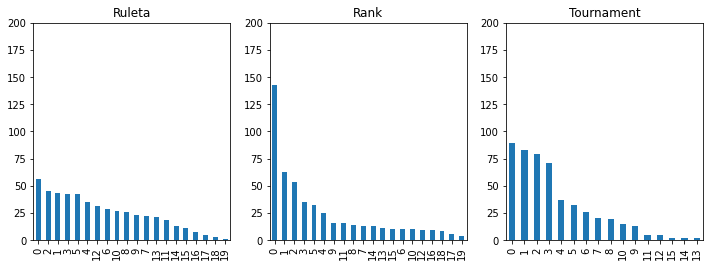

In [14]:
import matplotlib
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=3, figsize=(12, 4))

array_fitness = np.array([20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7,
                          6, 5, 4, 3, 2, 1])

probabilidad_seleccion = array_fitness / np.sum(array_fitness)
ind_seleccionado = np.random.choice(
                    a    = np.arange(len(array_fitness)),
                    size = 500,
                    p    = list(probabilidad_seleccion),
                    replace = True
                )
pd.value_counts(pd.Series(ind_seleccionado)).plot(kind="bar",
                                                  ylim=(0,200),
                                                  title = "Ruleta",
                                                  ax = axs[0])

order = np.flip(np.argsort(a=array_fitness) + 1)
ranks = np.argsort(order) + 1
probabilidad_seleccion = 1 / ranks
probabilidad_seleccion = probabilidad_seleccion / np.sum(probabilidad_seleccion)
ind_seleccionado = np.random.choice(
                    a    = np.arange(len(array_fitness)),
                    size = 500,
                    p    = list(probabilidad_seleccion),
                    replace = True
                   )
pd.value_counts(pd.Series(ind_seleccionado)).plot(kind="bar",
                                                  ylim=(0,200),
                                                  title = "Rank",
                                                  ax = axs[1])
indices_seleccionados = np.repeat(None,500)
for i in np.arange(500):
    # Se seleccionan aleatoriamente dos parejas de individuos.
    candidatos_a = np.random.choice(
                    a       = np.arange(len(array_fitness)),
                    size    = 2,
                    replace = False
                    )
    candidatos_b = np.random.choice(
                    a       = len(array_fitness),
                    size    = 2,
                    replace = False
                    )
    # De cada pareja se selecciona el de mayor fitness.
    if array_fitness[candidatos_a[0]] > array_fitness[candidatos_a[1]]:
        ganador_a = candidatos_a[0]
    else:
        ganador_a = candidatos_a[1]

    if array_fitness[candidatos_b[0]] > array_fitness[candidatos_b[1]]:
        ganador_b = candidatos_b[0]
    else:
        ganador_b = candidatos_b[1]

    # Se comparan los dos ganadores de cada pareja.
    if array_fitness[ganador_a] > array_fitness[ganador_b]:
        ind_seleccionado = ganador_a
    else:
        ind_seleccionado = ganador_b

    indices_seleccionados[i] = ind_seleccionado
    
pd.value_counts(pd.Series(indices_seleccionados)).plot(kind="bar", 
                                                       ylim=(0,200),
                                                       title = "Tournament",
                                                       ax=axs[2]);

Cuando no existe una gran diferencia entre el individuo de mayor fitness y el resto, con el método rank, el individuo con mayor fitness se selecciona con mucha más frecuencia que el resto. Con los otros dos métodos, la probabilidad de selección decae de forma más gradual.

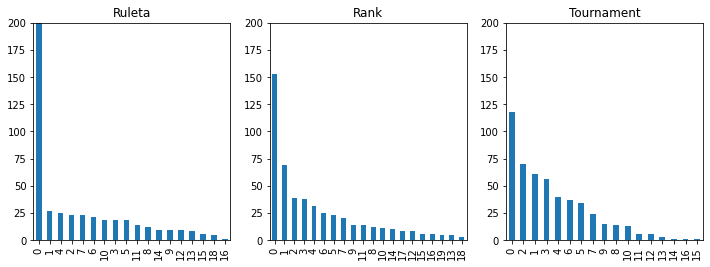

In [15]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 4))

array_fitness = np.array([200, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7,
                          6, 5, 4, 3, 2, 1])

probabilidad_seleccion = array_fitness / np.sum(array_fitness)
ind_seleccionado = np.random.choice(
                    a    = np.arange(len(array_fitness)),
                    size = 500,
                    p    = list(probabilidad_seleccion),
                    replace = True
                )
pd.value_counts(pd.Series(ind_seleccionado)).plot(kind="bar",
                                                  ylim=(0,200),
                                                  title = "Ruleta",
                                                  ax = axs[0])

order = np.flip(np.argsort(a=array_fitness) + 1)
ranks = np.argsort(order) + 1
probabilidad_seleccion = 1 / ranks
probabilidad_seleccion = probabilidad_seleccion / np.sum(probabilidad_seleccion)
ind_seleccionado = np.random.choice(
                    a    = np.arange(len(array_fitness)),
                    size = 500,
                    p    = list(probabilidad_seleccion),
                    replace = True
                   )
pd.value_counts(pd.Series(ind_seleccionado)).plot(kind="bar",
                                                  ylim=(0,200),
                                                  title = "Rank",
                                                  ax = axs[1])

indices_seleccionados = np.repeat(None,500)
for i in np.arange(500):
    # Se seleccionan aleatoriamente dos parejas de individuos.
    candidatos_a = np.random.choice(
                    a       = np.arange(len(array_fitness)),
                    size    = 2,
                    replace = False
                    )
    candidatos_b = np.random.choice(
                    a       = len(array_fitness),
                    size    = 2,
                    replace = False
                    )
    # De cada pareja se selecciona el de mayor fitness.
    if array_fitness[candidatos_a[0]] > array_fitness[candidatos_a[1]]:
        ganador_a = candidatos_a[0]
    else:
        ganador_a = candidatos_a[1]

    if array_fitness[candidatos_b[0]] > array_fitness[candidatos_b[1]]:
        ganador_b = candidatos_b[0]
    else:
        ganador_b = candidatos_b[1]

    # Se comparan los dos ganadores de cada pareja.
    if array_fitness[ganador_a] > array_fitness[ganador_b]:
        ind_seleccionado = ganador_a
    else:
        ind_seleccionado = ganador_b

    indices_seleccionados[i] = ind_seleccionado
    
pd.value_counts(pd.Series(indices_seleccionados)).plot(kind="bar",
                                                       ylim=(0,200),
                                                       title = "Tournament",
                                                       ax=axs[2]);

Cuando existe una gran diferencia entre el individuo de mayor fitness y el resto (uno o varios órdenes de magnitud), con el método ruleta, el individuo con mayor fitness se selecciona con mucha más frecuencia que el resto. A diferencia del caso anterior, en esta situación, la probabilidad de selección decae de forma más gradual con los métodos rank y tournament.

Teniendo en cuenta los comportamientos de selección de cada método, el método tournament parece ser la opción más equilibrada independientemente de la distribución de los fitness.

## Ejemplos Prácticos

### Optimización de una función (1 variable entrada)

In [23]:
def funcion_objetivo(x_0):
    """
    La función tiene muchos máximos locales.
    El máximo global se encuentra en:
    f(0) = 1
    """
    f = abs(np.sin(x_0)/x_0)
    return(f)

Gráfica de la función objetivo

Text(0, 0.5, 'f(x)')

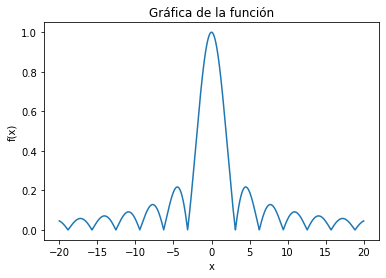

In [24]:
import matplotlib.pyplot as plt

# fig = plt.figure(figsize=(4, 3), dpi=200) # Por si se necesita ajustar el tamaño/calidad default

x = np.arange(-20, 20, 0.01)
y = np.array(funcion_objetivo(x))

plt.plot(x,y)
plt.title("Gráfica de la función")
plt.xlabel("x")
plt.ylabel("f(x)")

Proceso de optimización por algoritmo genético

`Queremos encontrar el máximo en este caso`

Luego, probar qué pasa respecto a los resultados al tratar de obtener el mínimo en una función cómo esta. Hay un sólo resultado posible?

In [28]:
poblacion = Poblacion(
    n_individuos = 10,  # Cantidad de individuos
    n_variables  = 1,   # Variables a optimizar, en este problema es 1, no se cambia
    limites_inf  = [-20],   # Límite inferior por cada n_variables, el orden es el índice de la lista
    limites_sup  = [20],    # Ídem pero para el límite superior
    verbose      = False    # Para mostrar o no mensajes de cada etapa del proceso
)

poblacion.optimizar(
    funcion_objetivo   = funcion_objetivo,
    optimizacion       = "maximizar",  # Para minimizar, el argumento es "minimizar"
    n_generaciones     = 50,           # Generaciones a evaluar, como mucho. Abajo hay un criterio para parada temprana
    metodo_seleccion   = "ruleta",     # Se puede optar por: 'ruleta', 'rank' o 'tournament'.
    elitismo           = 0.1,          # Probabilidad de elitismo
    prob_mut           = 0.01,
    distribucion       = "uniforme",   # "normal", "uniforme", "aleatoria"
    media_distribucion = 1,
    sd_distribucion    = 1,
    min_distribucion   = -1,
    max_distribucion   = 1,
    parada_temprana    = True,
    rondas_parada      = 10,           # Cantidad de generaciones consecutivas sin mejoras para decidir finalizar
    tolerancia_parada  = 10**-16,      # Resolución o tolerancia para computar si hay o no mejora respecto a la gen anterior
    verbose            = False
)

Algoritmo detenido en la generación 12 por falta cambio absoluto mínimo de 1e-16 durante 10 generaciones consecutivas.
-------------------------------------------
Optimización finalizada 2022-08-24 12:40:53
-------------------------------------------
Duración optimización: 0.04644942283630371
Número de generaciones: 12
Valor óptimo de las variables: [0.0024234684837487475]
Valor función objetivo: 0.9999990211337055



Visualización gráfica del resultado

Text(0.5, 1.0, 'Función objetivo y máximo encontrado')

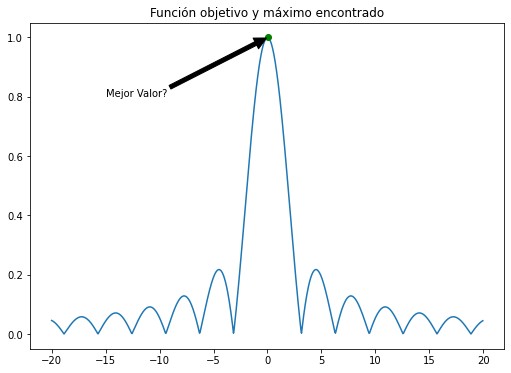

In [29]:
fig = plt.figure(figsize=(8.5, 6))

x = np.arange(-20, 20, 0.05)
y = np.array(funcion_objetivo(x))

plt.plot(x,y)

x_m = poblacion.mejor_valor_variables[0]
y_m = funcion_objetivo(x_m)

plt.plot(x_m, y_m, 'go')
plt.annotate('Mejor Valor?', xy=(x_m, y_m), xytext=(x_m-15, y_m-0.2),
             arrowprops=dict(facecolor='black', shrink=0.01),
             )
plt.title("Función objetivo y máximo encontrado")

Representación de la evolución de los individuos en el *Eje X*, con un gráfico animado

In [30]:
import matplotlib.animation as animation
import plotly_express as px
import plotly.io as pio
pio.renderers.default = "colab"

def extraer_posicion(individuo):
    posicion = individuo.valor_variables
    return(posicion)

lista_df_temp = []

for i in np.arange(len(poblacion.historico_individuos)):
    posiciones = list(map(extraer_posicion, poblacion.historico_individuos[i]))
    df_temp = pd.DataFrame({"generacion": i, "posicion": posiciones})
    lista_df_temp.append(df_temp)

df_posiciones = pd.concat(lista_df_temp)

df_posiciones[['x_0']] = pd.DataFrame(df_posiciones["posicion"].values.tolist(),
                                            index= df_posiciones.index)


px.scatter(
    df_posiciones,
    x       = "x_0",
    labels  = {"x_0": "Dominio de X", "index": "Individuos"},
    range_x = [-20,20],
    animation_frame = "generacion",
    width   = 700,
    height  = 450
)

### Optimización de una función (2 variables entrada)

In [31]:
def funcion_objetivo(x_0, x_1):
    """
    Para la región acotada entre −10<=x_0<=0 y −6.5<=x_1<=0 la función tiene
    múltiples mínimos locales y un único minimo global que se encuentra en
    f(−3.1302468,−1.5821422) = −106.7645367
    """
    f = np.sin(x_1)*np.exp(1-np.cos(x_0))**2 \
        + np.cos(x_0)*np.exp(1-np.sin(x_1))**2 \
        + (x_0-x_1)**2
    return(f)

Gráfica en 3D de la función objetivo

Text(0.5, 0, 'Y')

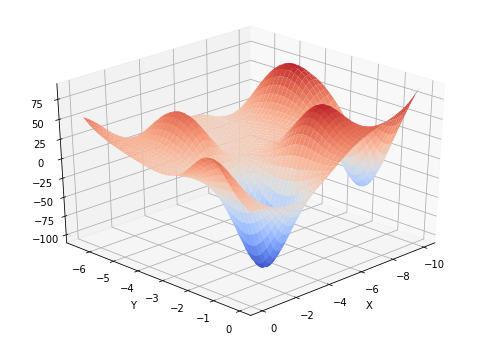

In [32]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure(figsize=(8.5, 6))
ax = fig.add_subplot(111, projection='3d')


# Grid de datos
x = np.arange(-10, 0, 0.05)
y = np.arange(-6.5, 0, 0.05)
x, y = np.meshgrid(x, y)
z = np.array(funcion_objetivo(np.ravel(x), np.ravel(y)))
z = z.reshape(x.shape)

grafico = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=1, antialiased=True)

ax.view_init(30, 45)
plt.xlabel("X")
plt.ylabel("Y")

Gráfica de contornos de la función objetivo (similar a un mapa de topografía)

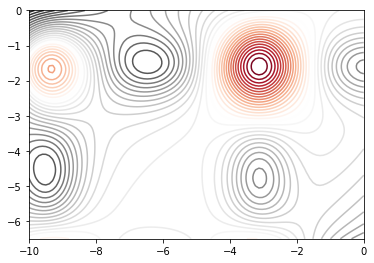

In [33]:
fig = plt.figure(figsize=(6, 4.2))
x_0 = np.linspace(start = -10, stop = 0, num = 100)
x_1 = np.linspace(start = -6.5, stop = 0, num = 100)
x_0, x_1 = np.meshgrid(x_0, x_1)
z = funcion_objetivo(x_0, x_1)
plt.contour(x_0, x_1, z, 35, cmap='RdGy');

Proceso de optimización por algoritmo genético

`Queremos encontrar el mínimo en este caso`

In [34]:
poblacion = Poblacion(
    n_individuos = 50,
    n_variables  = 2,
    limites_inf  = [-10, -6.5], # Acá hay 2 límites porque optimizamos 2 variables. Para la primera, los límites son -10 y 0. El superior está abajo.
    limites_sup  = [0, 0],
    verbose      = False
)

poblacion.optimizar(
    funcion_objetivo   = funcion_objetivo,
    optimizacion       = "minimizar",
    n_generaciones     = 250,
    metodo_seleccion   = "tournament",
    elitismo           = 0.1,
    prob_mut           = 0.01,
    distribucion       = "uniforme",
    media_distribucion = 1,
    sd_distribucion    = 1,
    min_distribucion   = -1,
    max_distribucion   = 1,
    parada_temprana    = True,
    rondas_parada      = 10,
    tolerancia_parada  = 10**-16,
    verbose            = False
)

Algoritmo detenido en la generación 19 por falta cambio absoluto mínimo de 1e-16 durante 10 generaciones consecutivas.
-------------------------------------------
Optimización finalizada 2022-08-24 12:43:08
-------------------------------------------
Duración optimización: 0.44200754165649414
Número de generaciones: 19
Valor óptimo de las variables: [-3.083110570946716 -1.6155543574296638]
Valor función objetivo: -106.59932337062959



Información sobre la población tras la optimización

In [35]:
poblacion

         Población
Número de individuos: 50
Límites inferiores de cada variable: [-10.   -6.5]
Límites superiores de cada variable: [0 0]
Optimizado: True
Iteraciones optimización (generaciones): 19

Información del mejor individuo:
----------------------------
Valor variables: [-3.083110570946716 -1.6155543574296638]
Fitness: 106.59932337062959

Resultados tras optimizar:
--------------------------
Valor óptimo de variables: [-3.083110570946716 -1.6155543574296638]
Valor óptimo función objetivo: -106.59932337062959
Fitness óptimo: 106.59932337062959

Representación gráfica de como ha evolucionado el mejor individuo en cada generación

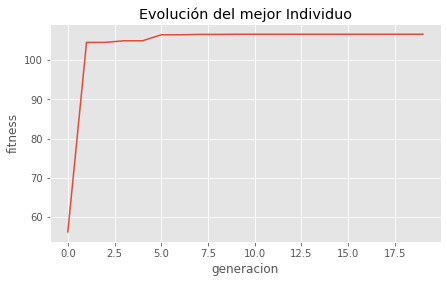

In [36]:
# Evolución de la optimización
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(7, 4))
poblacion.resultados_df.plot(x = "generacion",
                             y = "mejor_fitness",
                             ax= ax)
ax.set(title='Evolución del mejor Individuo', xlabel='generacion', ylabel='fitness')
ax.legend().set_visible(False)

Representación de la evolución de los individuos con un gráfico animado

In [37]:
import matplotlib.animation as animation
import plotly_express as px
import plotly.io as pio
pio.renderers.default = "colab"

def extraer_posicion(individuo):
    posicion = individuo.valor_variables
    return(posicion)

lista_df_temp = []

for i in np.arange(len(poblacion.historico_individuos)):
    posiciones = list(map(extraer_posicion, poblacion.historico_individuos[i]))
    df_temp = pd.DataFrame({"generacion": i, "posicion": posiciones})
    lista_df_temp.append(df_temp)

df_posiciones = pd.concat(lista_df_temp)

df_posiciones[['x_0','x_1']] = pd.DataFrame(df_posiciones["posicion"].values.tolist(),
                                            index= df_posiciones.index)


px.scatter(
    df_posiciones,
    x       = "x_0",
    y       = "x_1",
    labels  = {"x_0": "Dominio de X", "x_1": "Dominio de Y"},
    range_x = [-10, 0],
    range_y = [-6.5, 0],
    animation_frame = "generacion",
    width   = 700,
    height  = 450
)

Gráfica con el óptimo encontrado

Text(0.5, 1.0, 'Función objetivo y mínimo encontrado')

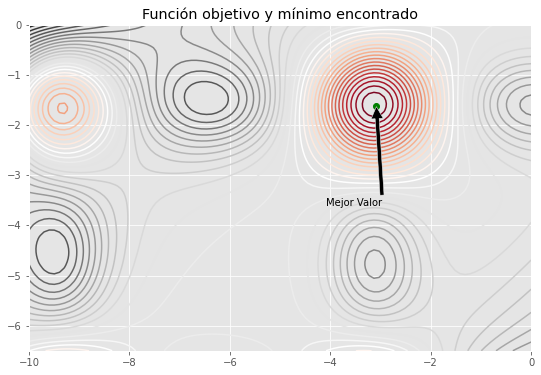

In [38]:
fig = plt.figure(figsize=(9, 6))
x_0 = np.linspace(start = -10, stop = 0, num = 100)
x_1 = np.linspace(start = -6.5, stop = 0, num = 100)
x_0, x_1 = np.meshgrid(x_0, x_1)
z = funcion_objetivo(x_0, x_1)
plt.contour(x_0, x_1, z, 35, cmap='RdGy');


x_m = poblacion.mejor_valor_variables[0]
y_m = poblacion.mejor_valor_variables[1]
plt.plot(x_m, y_m, 'go')
plt.annotate('Mejor Valor', xy=(x_m, y_m), xytext=(x_m-1, y_m-2),
             arrowprops=dict(facecolor='black', shrink=0.01),
             )
plt.title("Función objetivo y mínimo encontrado")

### Optimización de una función (N variables entrada)

De acá en más, ejemplos muy acotados/escuetos.

In [43]:
def funcion_objetivo(*d):
    """
    La función de Schwefel es compleja, con muchos mínimos/máximos locales.
    Esta implementación admite N dimensiones de entrada.

    Para más información:
    https://www.sfu.ca/~ssurjano/schwef.html
    """
    sum = 0
    for i in d:
        sum += i * np.sin(abs(i)**0.5)
    f = 418.9829*len(d) - sum
    return(f)

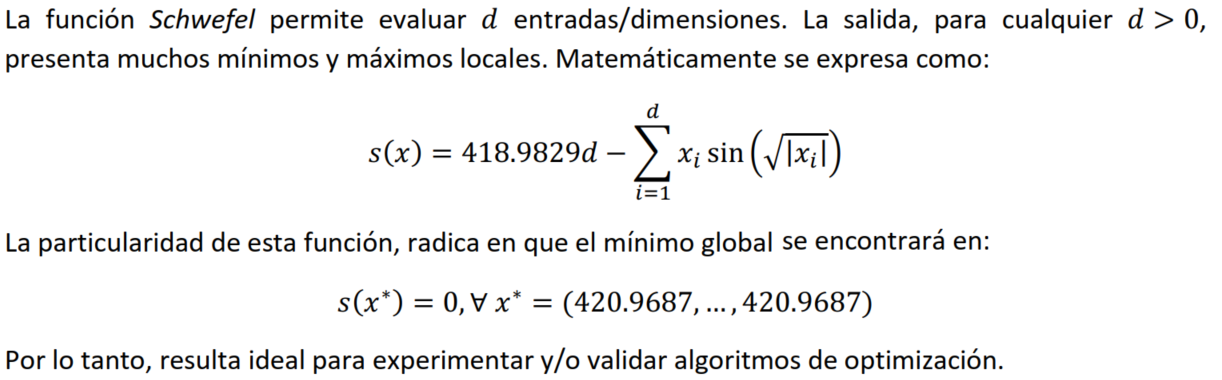

**1 Variable de entrada:**

Text(0.5, 1.0, 'Función Schwefel - 1D')

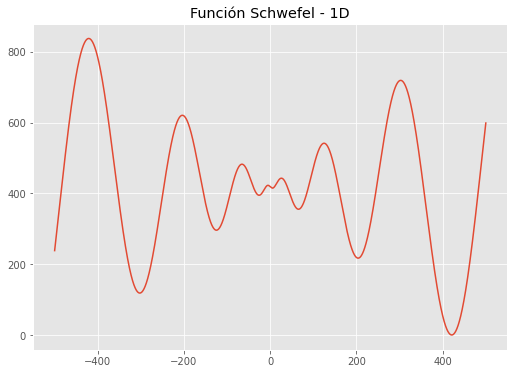

In [44]:
fig = plt.figure(figsize=(8.5, 6))

x = np.arange(-500, 500, 0.05)
y = np.array(funcion_objetivo(x))

plt.plot(x,y)

plt.title("Función Schwefel - 1D")

In [46]:
poblacion = Poblacion(
    n_individuos = 10,
    n_variables  = 1,
    limites_inf  = [-500],
    limites_sup  = [500],
    verbose      = False
)

poblacion.optimizar(
    funcion_objetivo   = funcion_objetivo,
    optimizacion       = "minimizar",
    n_generaciones     = 50,
    metodo_seleccion   = "tournament",
    elitismo           = 0.1,
    prob_mut           = 0.01,
    distribucion       = "uniforme",
    media_distribucion = 1,
    sd_distribucion    = 1,
    min_distribucion   = -1,
    max_distribucion   = 1,
    parada_temprana    = True,
    rondas_parada      = 10,
    tolerancia_parada  = 10**-16,
    verbose            = False
)

Algoritmo detenido en la generación 28 por falta cambio absoluto mínimo de 1e-16 durante 10 generaciones consecutivas.
-------------------------------------------
Optimización finalizada 2022-08-24 12:49:18
-------------------------------------------
Duración optimización: 0.10411310195922852
Número de generaciones: 28
Valor óptimo de las variables: [-302.54284143144486]
Valor función objetivo: 118.43838794698439



Text(0.5, 1.0, 'Función objetivo y máximo encontrado')

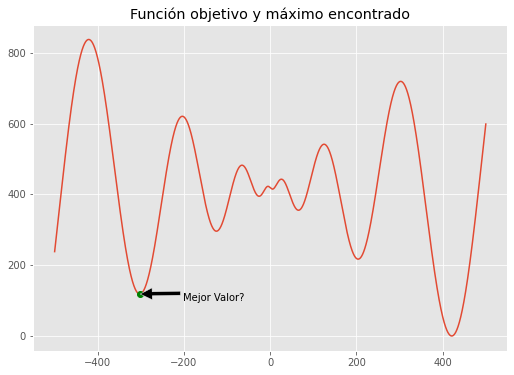

In [48]:
fig = plt.figure(figsize=(8.5, 6))

x = np.arange(-500, 500, 0.05)
y = np.array(funcion_objetivo(x))

plt.plot(x,y)

x_m = poblacion.mejor_valor_variables[0]
y_m = funcion_objetivo(x_m)

plt.plot(x_m, y_m, 'go')
plt.annotate('Mejor Valor?', xy=(x_m, y_m), xytext=(x_m+100, y_m-20),
             arrowprops=dict(facecolor='black', shrink=0.01),
             )
plt.title("Función objetivo y máximo encontrado")
# Algunos parámetros no son los ideales en la configuración, queda en evidencia los resultados
# Es importante entender la finalidad de todo lo que se establece/configura
# El criterio... se extrapola directamente a problemas reales, teniendo en cuenta el orden de magnitud
# de la función a optmizar por ejemplo, el área a mapear, etc.

**2 Variables de entrada:**

Text(0.5, 0.92, 'Función Schwefel - 2D')

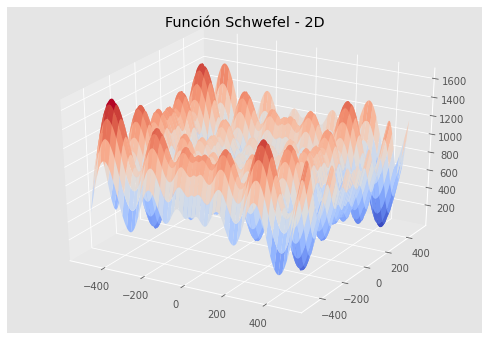

In [49]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure(figsize=(8.5, 6))
ax = fig.add_subplot(111, projection='3d')


# Grid de datos
x = np.arange(-500, 500, 1)
y = np.arange(-500, 500, 1)
x, y = np.meshgrid(x, y)
z = np.array(funcion_objetivo(np.ravel(x), np.ravel(y)))
z = z.reshape(x.shape)

grafico = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=1, antialiased=True)

plt.title("Función Schwefel - 2D")

In [50]:
poblacion = Poblacion(
    n_individuos = 60,
    n_variables  = 2,
    limites_inf  = [-500, -500],
    limites_sup  = [500, 500],
    verbose      = False
)

poblacion.optimizar(
    funcion_objetivo   = funcion_objetivo,
    optimizacion       = "minimizar",
    n_generaciones     = 250,
    metodo_seleccion   = "tournament",
    elitismo           = 0.1,
    prob_mut           = 0.01,
    distribucion       = "uniforme",
    media_distribucion = 1,
    sd_distribucion    = 1,
    min_distribucion   = -1,
    max_distribucion   = 1,
    parada_temprana    = True,
    rondas_parada      = 10,
    tolerancia_parada  = 10**-16,
    verbose            = False
)

Algoritmo detenido en la generación 73 por falta cambio absoluto mínimo de 1e-16 durante 10 generaciones consecutivas.
-------------------------------------------
Optimización finalizada 2022-08-24 12:58:34
-------------------------------------------
Duración optimización: 2.0669846534729004
Número de generaciones: 73
Valor óptimo de las variables: [420.99170943927555 420.95115804440076]
Valor función objetivo: 0.00013102713921853137



Text(0.5, 1.0, 'Función objetivo y mínimo encontrado')

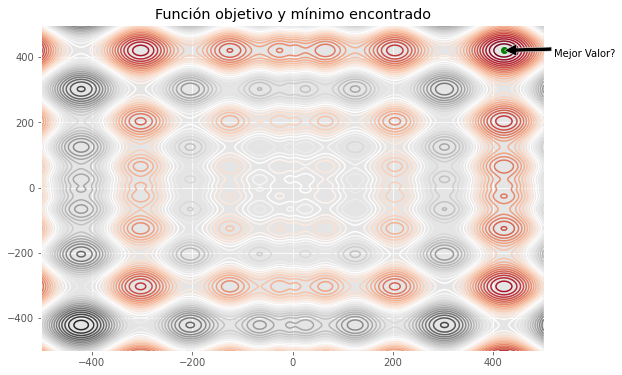

In [51]:
fig = plt.figure(figsize=(9, 6))
x_0 = np.linspace(start = -500, stop = 500, num = 1000)
x_1 = np.linspace(start = -500, stop = 500, num = 1000)
x_0, x_1 = np.meshgrid(x_0, x_1)
z = funcion_objetivo(x_0, x_1)
plt.contour(x_0, x_1, z, 35, cmap='RdGy');


x_m = poblacion.mejor_valor_variables[0]
y_m = poblacion.mejor_valor_variables[1]
plt.plot(x_m, y_m, 'go')
plt.annotate('Mejor Valor?', xy=(x_m, y_m), xytext=(x_m+100, y_m-20),
             arrowprops=dict(facecolor='black', shrink=0.01),
             )
plt.title("Función objetivo y mínimo encontrado")

**N Variables de entrada:**

In [53]:
LIM = 500   # Para los intervalos, debe ser positivo
D = 5       # Cantidad de variables

limites_inf = []
limites_sup = []

for i in range(D):
    limites_inf.append(-1*LIM)
    limites_sup.append(LIM)

poblacion = Poblacion(
    n_individuos = 60,
    n_variables  = D,
    limites_inf  = limites_inf,
    limites_sup  = limites_sup,
    verbose      = False
)

poblacion.optimizar(
    funcion_objetivo   = funcion_objetivo,
    optimizacion       = "minimizar",
    n_generaciones     = 250,
    metodo_seleccion   = "tournament",
    elitismo           = 0.1,
    prob_mut           = 0.01,
    distribucion       = "uniforme",
    media_distribucion = 1,
    sd_distribucion    = 1,
    min_distribucion   = -1,
    max_distribucion   = 1,
    parada_temprana    = True,
    rondas_parada      = 10,
    tolerancia_parada  = 10**-16,
    verbose            = False
)

# Para dimensiones altas... hablamos de hiperplanos
# Graficar no se puede, usar la imaginación es complejo
# En los problemas reales, es normal que existan muchas variables a tratar
# Aquí entra en juego la importancia de este tipo de algoritmos a la hora de "mapear" y
# encontrar una solución dentro de un vasto dominio.

Algoritmo detenido en la generación 81 por falta cambio absoluto mínimo de 1e-16 durante 10 generaciones consecutivas.
-------------------------------------------
Optimización finalizada 2022-08-24 13:00:56
-------------------------------------------
Duración optimización: 3.350172996520996
Número de generaciones: 81
Valor óptimo de las variables: [421.1488554904089 420.93909544852784 421.06408402381066
 421.00032054950015 420.88185204046994]
Valor función objetivo: 0.006493643815701944

